# Import data 

In [2]:
# Import necessary packages

import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.stats import norm
import math

In [3]:
# Set tickers to download
liste_company = [
    "LVMH"
]
liste_tickers_to_download = [
    "MC.PA"
]


# Function to download data historic by their tickers name
def download_data(ticker_name, company_name):
    data_ticker = yf.download(
        tickers=ticker_name,
        start="2022-01-01",
        end="2022-12-31",  # time period
        interval="1d",  # trading interval
        ignore_tz=True,  # ignore timezone when aligning data from different exchanges?
        prepost=False)  # download pre/post market hours data?

    # keep only the close price, and rename the column by the ticker name
    df = data_ticker[['Close']]
    df = df.rename(columns={'Close': company_name})
    df.reset_index(inplace=True)

    # Keep only last price of each month and compute returns
    df = df.reset_index(drop=True)
    df['Date'] = pd.to_datetime(df['Date']).dt.strftime('%Y-%m-%d')

    return (df)

In [4]:
liste_df = []
for n in range(0, len(liste_tickers_to_download)):
    exec(
        f"df_{n} = download_data(liste_tickers_to_download[n], liste_company[n])")
    liste_df.append('df_'+str(n))
df_0

[*********************100%***********************]  1 of 1 completed


,Date,LVMH
0,2022-01-03,731.000000
1,2022-01-04,744.000000
2,2022-01-05,758.000000
3,2022-01-06,727.099976
4,2022-01-07,715.799988
...,...,...
252,2022-12-23,673.799988
253,2022-12-27,690.200012
254,2022-12-28,686.599976
255,2022-12-29,696.500000


# Part 2

In [6]:
#We compute Returns of the this stock prices
df_0['Log_returns'] = np.log(df_0['LVMH']/df_0['LVMH'].shift())
dfLog = df_0['Log_returns'].dropna()

# We can now calculate the variance of the returns
mean = sum(dfLog) / len(dfLog)
squared_diffs = 0
for x in dfLog:
    squared_diffs += (x - mean) ** 2
    
variance = squared_diffs / (len(dfLog) - 1)
print(variance)

# Standard Deviation
std = variance **0.5
print(std)

ann_volatility = std*np.sqrt(252)
print(ann_volatility)

0.0004396362230329228
0.020967503977176748
0.3328488068242044


Text(0.5, 1.0, 'LVMH volatility: 33.0%')

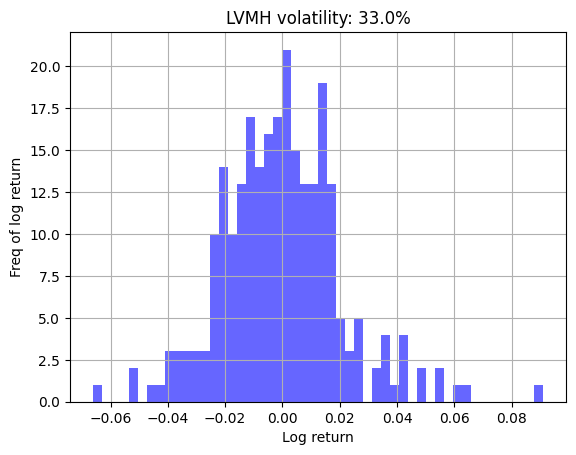

In [7]:
# Plot log returns
str_vol = str(round(ann_volatility, 2)*100)

fig, ax = plt.subplots()
df_0['Log_returns'].hist(ax=ax, bins=50, alpha=0.6, color='b')
ax.set_xlabel('Log return')
ax.set_ylabel('Freq of log return')
ax.set_title('LVMH volatility: ' + str_vol + '%')

# Part 3

In [16]:
# Compute the normal probability according to the cumulative table
def N_(d):
    return norm.cdf(d)

# Compute call and put prices 
def bsm_model(So, X, r, T, ann_volatility):

    d1 = (np.log(So/X) + (r + (0.5 * ann_volatility**2)) * T)/(ann_volatility * T**0.5)
    d2 = d1 - (ann_volatility * T**0.5)

    call = (So * N_(d1)) - (X * math.e**(-(r*T)) * N_(d2))
    put = (X * math.e**(-(r*T)) * (1 - N_(d2))) - (So * (1 - N_(d1)))

    return [call, put, d1, d2]

In [12]:
# DataFrame of risk free rates according to their maturity
# Date of observation 30/12/2022
# Source : ECB

maturities = ["3M", "6M", "9M", "1Y", "3Y", "5Y", "10Y", "15Y", "20Y", "25Y", "30Y"]
rates = [1.710096, 2.092719, 2.325662, 2.460508, 2.502110, 2.450907, 2.555314, 2.609120, 2.584189, 2.514190, 2.424461]


rfrates = pd.DataFrame([rates], columns = maturities)
rfrates

,3M,6M,9M,1Y,3Y,5Y,10Y,15Y,20Y,25Y,30Y
0,1.710096,2.092719,2.325662,2.460508,2.50211,2.450907,2.555314,2.60912,2.584189,2.51419,2.424461


In [19]:
So = list(df_0.LVMH.values)[-1]

# Setting exercise prices as asked in instructions of the project
X1 = np.mean(df_0['LVMH'])
X2 = So * 1.1
print(So, X1, X2)
X = X2

# As a rfr, we select the 1y german bonds yield which we found on Investing.com
rfr = rfrates["1Y"]
T = 1

r = (rfr/100)**(1/T)


# Set T according to the maturity of the risk free rate
ann_volatility = ann_volatility

679.9000244140625 645.6003900075237 747.8900268554688


In [17]:
#With X equals our current market price for our asset with a 10% deviation up  
bsm_model(So, X, r, T, ann_volatility)

[0    70.326532
 Name: 1Y, dtype: float64,
 0    120.139185
 Name: 1Y, dtype: float64,
 0   -0.046
 Name: 1Y, dtype: float64,
 0   -0.378848
 Name: 1Y, dtype: float64]

In [20]:
#With X equals the mean of our asset's market price data 
bsm_model(So, X1, r, T, ann_volatility)

[0    113.805136
 Name: 1Y, dtype: float64,
 0    63.814286
 Name: 1Y, dtype: float64,
 0    0.395868
 Name: 1Y, dtype: float64,
 0    0.063019
 Name: 1Y, dtype: float64]

In [31]:
# Payoff
# St market price of the asset at maturity T
# n = number of call options purchased
#We keep X as our current asset's market price with a 10% deviation up

call, put, d1, d2 = bsm_model(So, X, r, T, ann_volatility)

def results(St, n=1):    
    results = [0, St - X]
    payoff = n * max(results)
    pnl = payoff - (call.item() * n)
#     print('Payoff :', payoff,
#          'PnL :', pnl)
    return [payoff, pnl]

St = 800
# n = 10000

payoff, pnl = results(St)
results(St)

[52.10997314453118, -18.216558871993925]

# Part 4
Change in parameters

In [34]:
# Change in the price of the underlying asset
# Delta = N(d1)

deltaC = N_(d1).item()
print(deltaC)
deltaP = N_(d1).item() - 1
print(deltaP)

0.48165525595435515
-0.5183447440456448


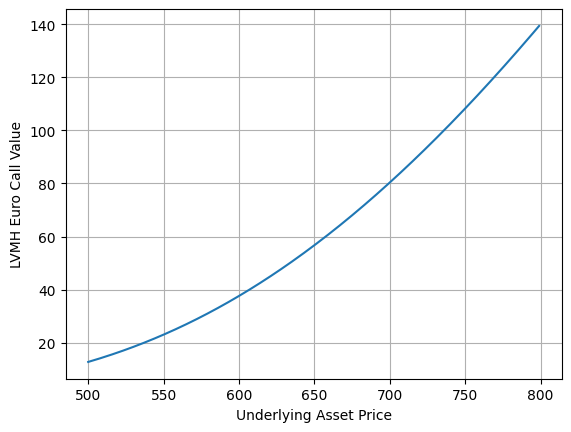

In [35]:
#Visually for Call Option value
plt.plot(range(500,800),[bsm_model(s, X, r, T, ann_volatility)[0] for s in range(500,800)])
plt.xlabel('Underlying Asset Price')
plt.ylabel('LVMH Euro Call Value')
plt.grid()

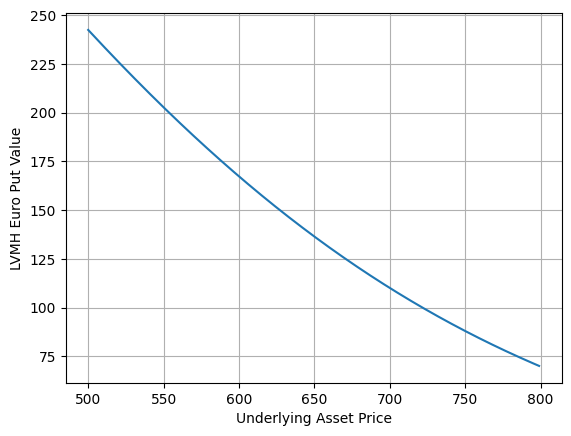

In [36]:
#Visually for Put Option value

plt.plot(range(500,800),[bsm_model(s, X, r, T, ann_volatility)[1] for s in range(500,800)])
plt.xlabel('Underlying Asset Price')
plt.ylabel('LVMH Euro Put Value')
plt.grid()

In [37]:
# Change in the delta : gamma
def N_2(x):
    return (1/(math.sqrt(2*math.pi)))*math.exp(-((x**2)/2))

gamma = N_2(d1)/(So*ann_volatility*math.sqrt(T))
gamma

0.001760996641090296

In [38]:
# Change of the value with time : theta

def theta(x, y):
    call = -((So*N_2(x.item())*ann_volatility)/(2*math.sqrt(T))) - r*X*math.exp(-r*T)*N_(y.item())
    thetaC = call/252
    
    put = -((So*N_2(x.item())*ann_volatility)/(2*math.sqrt(T))) + r*X*math.exp(-r*T)*N_(-y.item())
    thetaP = put/252
    
    return [thetaC, thetaP]

In [39]:
theta(d1, d2)

[0   -0.20405
 Name: 1Y, dtype: float64,
 0   -0.132801
 Name: 1Y, dtype: float64]

In [40]:
# Sensibility of the option's price to change in volatility
vega = So * N_2(d1) * math.sqrt(T)
percentage_change = -1.9/100
Vprice_change = vega * percentage_change

print('A decrease of 1.9% of volatility will cause a ' + "${:,.2f}".format(Vprice_change) + ' change on the price option')

A decrease of 1.9% of volatility will cause a $-5.15 change on the price option


In [41]:
# Option's sensitivity to changes in risk-free rate
#Rho

def rho(x):
    # perc for the percentage of change in the risk-free rate
    rhoC = X * T * math.exp(-r*T) * N_(x.item())
    rhoP = -X * T * math.exp(-r*T) * N_(-x.item())
    return [rhoC, rhoP]    

percentage_change = 0.7/100

Rprice_change = rho(d2)[0] * percentage_change
print(rho(d2)[0], rho(d2)[1])


257.1508882660025 -472.56178926772014


In [42]:
variables = ["S0", "X", "St", "Volatility", "r", 
             "Call Price", "Put Price", "Call Payoff", "Call PnL", 
             "Call Delta", "Put Delta", "Gamma", "Call Theta", "Put Theta", "Vega", "Call Rho"]
results = [So, X, St, ann_volatility, r.item(), 
           call.item(), put.item(), payoff, pnl, 
          deltaC, deltaP, gamma, theta(d1, d2)[0].item(), theta(d1, d2)[1].item(), Vprice_change, Rprice_change]

resume = pd.DataFrame([results], columns = variables).T
resume = resume.rename(columns={0:'Value'})
resume

,Value
S0,679.900024
X,747.890027
St,800.000000
Volatility,0.332849
r,0.024605
Call Price,70.326532
Put Price,120.139185
Call Payoff,52.109973
Call PnL,-18.216559
Call Delta,0.481655


# Part 4
OPTIONS HEDGING STRATEGIES

- Delta hedging

In [45]:
# Delta Hedging : Covered Call
# Nb of shares : 15 000
nbShares = 15000
deltaHedge = round(nbShares / deltaC)
print(deltaHedge)
# 1 contract = 100 options

print("To create a delta-neutral position, the investor will have to sell", round(deltaHedge/100), "call options contracts")

31143
To create a delta-neutral position, the investor will have to sell 311 call options contracts


In [48]:
# Effect on the portofolio value in case of a 0.67$ increase in the price of the stock (LVMH)
deltaS = 0.67

#Reminder : the delta for a call option is the variable deltaC computed previously
#Cahnge in the option price will be :

deltaO = deltaC * deltaS

#Let's check the impact on the portofolio
#Change in the value of the stock position
stockPosition = nbShares * deltaS
print("Total value of increase in the stock position :", stockPosition)

#Change in the value of option position
optionPosition = round(deltaHedge * (-deltaO))
print("Total value of decrease in the option position :", optionPosition)

#Change in portofolio
portofolioChange = stockPosition + optionPosition
print("Total change in portfolio value :", portofolioChange)



Total value of increase in the stock position : 10050.0
Total value of decrease in the option position : -10050
Total change in portfolio value : 0.0


In [60]:
#Since there is a change in the stock price, it impacts the delta
#We compute the new delta for a call option with our new spot price
change = 0.67
newDeltaCall = N_(bsm_model(So+change, X, r, T, ann_volatility)[2]).item()

print("Difference in the deltas after a 0.67$ increase of the stock price :", newDeltaCall - deltaC)

difference in the deltas after a 0.67$ increase of the stock price : 0.0011793653322498265


In [61]:
#We will now see if we need to rebalance our portofolio
newDeltaHedge = round(nbShares / newDeltaCall)
print("To create a delta-neutral position with the new stock price, the investor will have to sell", round(deltaHedge/100), "call options contracts")

To create a delta-neutral position with the new stock price, the investor will have to sell 311 call options contracts


We already have a short position on 311 call option contracts, this change in LVMH stock prices doesn't affect our portofolio

- Gamma Hedging

(website : https://www.optionistics.com/calculators/stock-option-calculator/AAPL)

In [66]:
# For this strategy, we need informations anbout an instrument not linearly related to the underlying instrument
# We're gonna selct a random option with its respective delta and gamma values.
# For a long option position on Apple stocks
#AAPL call option expiring in january 2024 :
AAPLdelta = 0.5005
AAPLgamma = 0.89

# We have 15000 shares, and short on 311 call options contracts
# Our position is delta neutral
# Let's make gamma neutral

gammaNeutral = -(-gamma/AAPLgamma)
gammaNeutral

#Since our gamma is close to 0, we don't need to add a lot of other options to obtain gamma neutrality

0.0019786479113374114

To continue the exercice, let's suppose that we can buy sliced of options

In [71]:
print("An investor has to buy ", round(gammaNeutral, 5), "options to gamma hedge")

#Added options have changed the delta position of the portofolio

sell = gammaNeutral * AAPLdelta

print(round(sell, 6), "shares will have to be sold in order to obtain the Delta-Gamma neutral position")

An investor has to buy  0.00198 options to gamma hedge
0.00099 shares will have to be sold in order to obtain the Delta-Gamma neutral position
